In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import random
import itertools


import warnings
warnings.filterwarnings('ignore')

data = pd.read_pickle("ass3.pickle")
train = data["train"].to_numpy()

X_train = train[:, :-1]
y_train = train[:, -1]

test = data["test"].to_numpy()
X_test = test[:, :-1]
y_test = test[:, -1]

dev = data["dev"].to_numpy()
X_dev = dev[:, :-1]
y_dev = dev[:, -1]



Preliminary data analysis:

In [98]:
print(f"number of attributes: {X_train.shape[1] - 1}\n")
print(f"number of samples:\n\ttrain: {X_train.shape[0]}, test: {X_test.shape[0]}, dev: {X_dev.shape[0]}\n")

train_num_of_nulls = np.sum(np.isnan(X_train))
print(f"number of nulls in train: {train_num_of_nulls}")

test_num_of_nulls = np.sum(np.isnan(X_test))
print(f"number of nulls in test: {test_num_of_nulls}")

dev_num_of_nulls = np.sum(np.isnan(X_dev))
print(f"number of nulls in dev: {dev_num_of_nulls}")


number of attributes: 7

number of samples:
	train: 12384, test: 4128, dev: 4128

number of nulls in train: 1238
number of nulls in test: 0
number of nulls in dev: 0


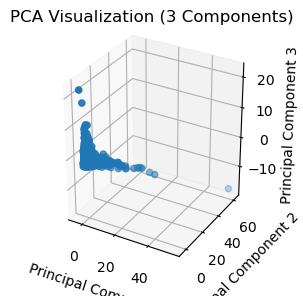

In [99]:
# Impute the issing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

# Scale the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_dev_scaled = scaler.fit_transform(X_dev)

# Merge the train and dev datasets
X_train_and_dev_scaled = np.vstack((X_train_scaled, X_dev_scaled))
y_train_and_dev = np.hstack((y_train, y_dev))

# PCA visualisation
pca = PCA(n_components=3)
pca.fit(X_train_and_dev_scaled)
X_pca = pca.transform(X_train_and_dev_scaled)

fig1 = plt.figure(figsize=(4, 3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2])
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_zlabel('Principal Component 3')
ax1.set_title('PCA Visualization (3 Components)')
ax1.set_box_aspect([1, 1, 1.2])

plt.show()

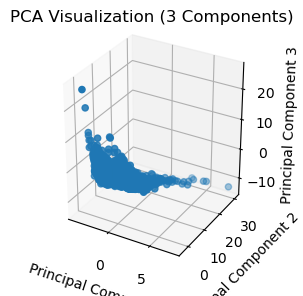

In [100]:
# Remove outlier
outlier_1_index = np.argmax(X_pca[:, 0])
X_train_and_dev_scaled = np.delete(X_train_and_dev_scaled, outlier_1_index, axis=0)
y_train_and_dev = np.delete(y_train_and_dev, outlier_1_index)
# outlier_2_index = np.argmax(X_pca[:, 2])
# X_train_and_dev_scaled = np.delete(X_train_and_dev_scaled, outlier_2_index, axis=0)
# outlier_3_index = np.argmax(X_pca[:, 2])
# X_train_and_dev_scaled = np.delete(X_train_and_dev_scaled, outlier_3_index, axis=0)

# PCA visualisation without outliers
pca.fit(X_train_and_dev_scaled)
X_pca = pca.transform(X_train_and_dev_scaled)

fig2 = plt.figure(figsize=(4, 3))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2])
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
ax2.set_title('PCA Visualization (3 Components)')
ax2.set_box_aspect([1, 1, 1.2])

plt.show()

-------------------------------------- flow --------------------------------------

TODO

In [101]:
models = {
            'KNN': KNeighborsRegressor,
            'Decision Tree': DecisionTreeRegressor,
            'Random Forest': RandomForestRegressor,
            'Linear Regression': LinearRegression, 
            'Gradient Boosting': GradientBoostingRegressor,
            'AdaBoost': AdaBoostRegressor,            
        }

best_model = None
best_model_name = ""
best_r2 = 0

for name, model_class in models.items():
    model = model_class()
    print(f"{name}:")

    # fit the model on the train_and_dev data
    clf = model.fit(X_train_and_dev_scaled, y_train_and_dev)
    y_pred = clf.predict(X_test_scaled)
           
    # r2 score
    y_pred = model.predict(X_test_scaled)
    model_r2 = r2_score(y_test, y_pred)
    print(f"r2 = {model_r2}\n")
    
    if (model_r2 > best_r2):
        best_r2 = model_r2
        best_model = model
        best_model_name = name
                
print(f"\nBest model when fit to the original data (unbalanced) with default hyperparameters:\n{best_model_name}")
print(f"r2: {best_r2}")


KNN:
r2 = 0.7091018793902755

Decision Tree:
r2 = 0.5682137368549411

Random Forest:
r2 = 0.7905899327375774

Linear Regression:
r2 = 0.6285295449718902

Gradient Boosting:
r2 = 0.7628238458733864

AdaBoost:
r2 = 0.36364329117704375


Best model when fit to the original data (unbalanced) with default hyperparameters:
Random Forest
r2: 0.7905899327375774


We can see that Random Forest is the best performing model, so we will try to optimize it by checking different combinations of hyperparameters.

When using 'r2' as the scoring metric in GridSearchCV, it means that the grid search will evaluate the different parameter combinations based on how well they maximize r2 value. The goal is to find the parameter combination that yields the highest r2 score, indicating the best fit of the model to the data.


In [ ]:
hyperparameters = {
    'n_estimators': [i*100 for i in range(1, 11)],
    'max_depth': [None] + [i*5 for i in range(1, 7)],
    'min_samples_split': [i*2 for i in range(1, 11)]
}

model = models[best_model_name]()

# # Create a RandomizedSearchCV object
# randomized_search = RandomizedSearchCV(estimator=model, param_distributions=hyperparameters, scoring='r2', n_jobs=-1)

# # Fit the RandomizedSearchCV object to the data
# randomized_search.fit(X_train_and_dev_scaled, y_train_and_dev)

# # Get the best hyperparameters
# best_params = randomized_search.best_params_

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=5, scoring='r2', n_jobs=-1)

# Fit the GridSearchCV object to your data
grid_search.fit(X_train_and_dev_scaled, y_train_and_dev)

# Get the best hyperparameters
best_params = grid_search.best_params_

print("best combination chosen: ", best_params)

# Unpacking the best_params dict into the model constructor
model = models[best_model_name](**best_params)

clf = model.fit(X_train_and_dev_scaled, y_train_and_dev)
    
y_pred = model.predict(X_test_scaled)
model_r2 = r2_score(y_test, y_pred)
print(f"r2 score of {best_model_name} after hyperparameter optimization = {model_r2}\n")
